### Forecasting with *approxposterior*

---

In this notebook, I show how *approxposterior* can be used to forecast where the forward model should be run next according to the BAPE formalism.

In [1]:
%matplotlib inline

from __future__ import (print_function, division, absolute_import,
                        unicode_literals)
from approxposterior import bp, likelihood as lh, gp_utils, plot_utils as pu, utility as ut
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams.update({'font.size': 18})

In [2]:
seed = 42
np.random.seed(seed)

**Initialize model parameters**

---

Set model parameters like the size of the initial dataset to simulate, *m0*, and the number of new points to forecast, *m*.

In [3]:
# Initialize 
m0 = 40                           # Initial size of training set (will simulate below)
m = 5                             # Number of new points to find
which_kernel = "ExpSquaredKernel" # Which Gaussian Process kernel to use
bounds = ((-5,5), (-5,5))         # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2015) BAPE formalism

**Simulate a training set**

---

Here, we use the Rosenbrock function example from Wang & Li (2017).

In [4]:
theta = lh.rosenbrock_sample(m0) # Sample forward model initial conditions from our priors
y = lh.rosenbrock_lnlike(theta) # Compute the log likelihood of each point

** Training and optimize a GP using the training set**

---

We won't use this GP for forecasting, instead, we'll use it to see what the GP sees in parameter space: what is it's mean prediction and variance at each point?  What is the value of the BAPE utility function at each point in parameter space?  This will allow us to visually see where we should simulate next.  Ideally in the BAPE formalism, it is best to simulate in high likelihood regions where the predictions are currently uncertain, i.e. where the predictive mean (a proxy for the likelihood) is large and where the preditive variance is large (GP is uncertain).  Simulating in these regions is optimal because simulating in low likelihood regions and/or where the prediction is certain is a waste of time as a GP prediction will more than suffice.

In [5]:
gp = gp_utils.setup_gp(theta, y, which_kernel=which_kernel, seed=seed)
gp = gp_utils.optimize_gp(gp, theta, y, seed=seed, which_kernel=which_kernel)

**Compute what the GP sees throughout parameter space**

---

Easy to do with a simple double for loop for our 2D parameter space.  Note that *approxposterior* works with *negative* log likelihoods (GP predictive means).

In [6]:
num = 100

xx = np.linspace(-5, 5, num)
yy = np.linspace(-5, 5, num)
zzVar = np.zeros((len(xx),len(yy)))
zzMean = np.zeros_like(zzVar)
zzUtility = np.zeros_like(zzVar)
    
# Compute GP variances, mean and the utility function at each point
for ii in range(len(xx)):
    for jj in range(len(yy)):
        mu, var = gp.predict(y, np.array([xx[ii],yy[jj]]).reshape(1,-1), return_var=True)
        zzVar[ii,jj] = var
        zzMean[ii,jj] = mu
        zzUtility[ii,jj] = (2.0*mu + var) + ut.logsubexp(var, 0.0)
        
#Threshold negative values for logscale plotting
zzUtility[zzUtility < 0] = 1.0e-2
zzMean[zzMean < 0] = 1.0e-2

** Plot it!**

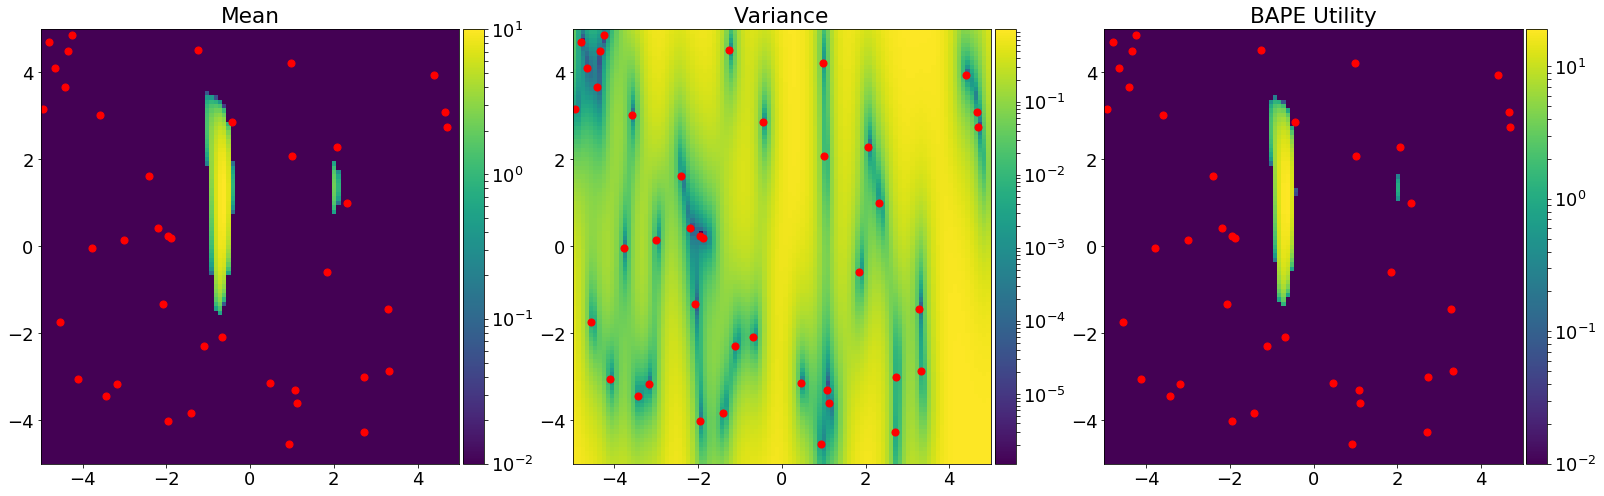

In [7]:
# Plot what the GP thinks everything looks like
normMean = LogNorm(vmin=np.abs(zzMean).min(), vmax=np.abs(zzMean).max())
normVar = LogNorm(vmin=zzVar.min(), vmax=zzVar.max())
normUtility = LogNorm(vmin=zzUtility.min(), vmax=zzUtility.max())

fig, axes = plt.subplots(ncols=3, figsize=(27,8))

# Left: Mean
im0 = axes[0].pcolormesh(xx, yy, np.fabs(zzMean).T, norm=normMean)

divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')
axes[0].set_title("Mean")

# Middle: Variance
im1 = axes[1].pcolormesh(xx, yy, zzVar.T, norm=normVar)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
axes[1].set_title("Variance")

# Right: Utility
im2 = axes[2].pcolormesh(xx, yy, np.fabs(zzUtility).T, norm=normUtility)
divider2 = make_axes_locatable(axes[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
axes[2].set_title("BAPE Utility")

# Scatter plot where the points are, format axes
for ax in axes:
    ax.scatter(theta[:,0], theta[:,1], color="red", s=50)
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)

**Initialize an *approxposterior* object**

---

As before, we'll use the Wang & Li (2017) Rosenbrock function example.  We'll use the *ApproxPosterior* object's *forecast* method to predict where in parameter space we should simulate next to best improve the GP's performance.

In [8]:
ap = bp.ApproxPosterior(lnprior=lh.rosenbrock_lnprior,
                        lnlike=lh.rosenbrock_lnlike,
                        prior_sample=lh.rosenbrock_sample,
                        algorithm=algorithm)

*Forecast!*

---

To make a prediction, you need forward model input-output pairs, theta and y, which kernel to use for the GP, prior bounds, and optionally, a RNG seed.

In [10]:
theta_hat = ap.forecast(theta=theta, y=y, seed=seed, which_kernel=which_kernel, bounds=bounds)

** Plot it!**

---

Let's plot the new forecasted points (in blue) to see where *approxposterior* thinks it's best to simulate.

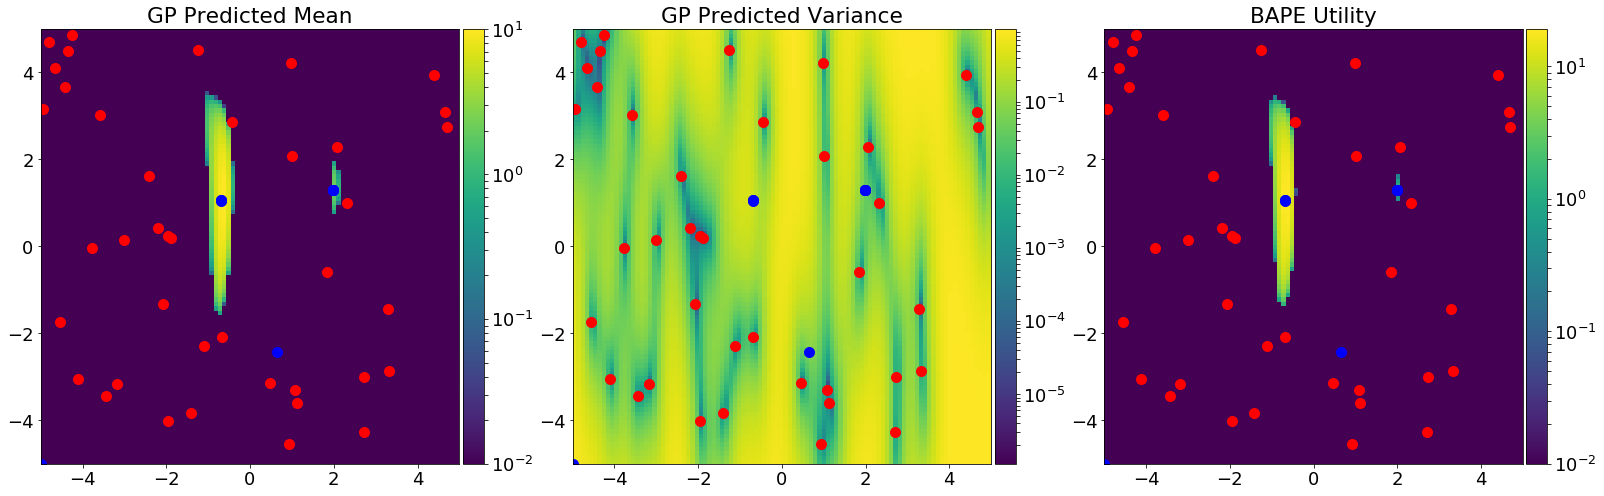

In [11]:
# Plot what the GP thinks everything looks like, but this time with the new points!
fig, axes = plt.subplots(ncols=3, figsize=(27,8))

# Left: Mean
im0 = axes[0].pcolormesh(xx, yy, np.abs(zzMean).T, norm=normMean)

divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax0, orientation='vertical')
axes[0].set_title("GP Predicted Mean")

# Middle: Variance
im1 = axes[1].pcolormesh(xx, yy, zzVar.T, norm=normVar)
divider1 = make_axes_locatable(axes[1])
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
axes[1].set_title("GP Predicted Variance")

# Right: Utility
im2 = axes[2].pcolormesh(xx, yy, zzUtility.T, norm=normUtility)
divider2 = make_axes_locatable(axes[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
axes[2].set_title("BAPE Utility")

# Scatter plot where old, new points are, also, format axes
for ax in axes:
    ax.scatter(theta[:,0], theta[:,1], color="red", s=100)
    ax.scatter(theta_hat[:,0], theta_hat[:,1], color="blue", s=100)
    
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)

**It works!**

---

Note how the forecasted points (blue) are preferentially located in high mean, high variance regions of parameter space.  These points correspond to regions where the utility function is large.  This example is convex as the Rosenbrock function has a global minimum, so a few of the forecast points can overlap.  This likely won't be as much of an issue for more complex models.